本笔记由马景义, 赖楸鸿完成, 如有任何错误欢迎向两位编者反馈.

## 一些常用的公式

（1）链式法则：若$y(x)$为$x$的向量函数，则
$$ \frac{\partial f(y(x))}{\partial x} = \frac{\partial y^T(x)}{\partial x}\frac{\partial f(y)}{\partial y} ,$$
其中$\frac{\partial y^T(x)}{\partial x}$为$n\times n$矩阵。

（2）$a$为$n\times1$常数向量，则
$$\frac{\partial a^Tx}{\partial x}= a ,$$
$$\frac{\partial x^Ta}{\partial x}= a.$$

（3）$a$为$n\times1$常数向量，则
$$\frac{\partial a^Ty(x)}{\partial x}=\frac{\partial y^T(x)}{\partial x}a ,$$
$$\frac{\partial y^T(x)a}{\partial x}=\frac{\partial y^T(x)}{\partial x}a.$$

（4）矩阵$A$和向量$y$与$x$无关，则$$\frac{\partial x^TAy}{\partial x}=Ay ,$$
$$\frac{\partial y^TAx}{\partial x}= A^Ty.$$

（5）矩阵$A$和向量$y$与$x$无关，则
$$\frac{\partial x^TA}{\partial x}=A ,$$
$$\frac{\partial x^TAx}{\partial x}=Ax+A^Tx=(A+A^T)x.$$

链式法则搭配后面四条可以衍生出许多公式，感觉已经非常够用了~

## 岭回归的求导部分

$$
L(\beta)=(Y-X\beta)^T(Y-X\beta)+\beta^T\lambda\beta ,$$
其中$Y$为$n\times1$向量，$X$为$n\times p+1$矩阵，$\beta$为$p+1\times1$向量，$\lambda$为$p+1\times p+1$矩阵,即
$$\lambda= \left[\begin{matrix}0 &0&\cdots&0 \\ 0&\lambda&\cdots&0\\ \vdots&\vdots&\ddots&\vdots\\0&0&\cdots&\lambda \end{matrix}\right].$$


$$
\begin{split}
&\frac{\partial L(\beta)}{\partial \beta} \\
=&\frac{\partial (Y-X\beta)^T(Y-X\beta)}{\partial \beta}+\frac{\partial \beta^T\lambda\beta}{\partial \beta} \\
=&\frac{\partial (Y-X\beta)^T}{\partial \beta}[(Y-X\beta)+(Y-X\beta)]+(\lambda+\lambda^T)\beta \\
=&-2X^T(Y-X\beta)+2\lambda\beta
\end{split}
$$


In [34]:
###mchol函数将对称方阵分解为一个下三角矩阵乘以该矩阵转置的形式,函数返回值为下三角矩阵
#输入：欲分解的矩阵x
#输出：cholesky分解所得矩阵L
#cholesky decomposition详见：https://en.wikipedia.org/wiki/Cholesky_decomposition
mchol <- function(x)
{
  #求矩阵x的行列数,m为行数,n为列数
  mn <- dim(x)
  m <- mn[1]
  n <- mn[2]

  #检验x是否为方阵
  if(m != n) 
  {
    return ("Wrong dimensions of matrix!")
  }

  #检验x是否为对称矩阵
  if(sum(t(x) != x) > 0) 
  {
    return ("Input matrix is not symmetrical!")
  }

  #L为与x行列数相等的零矩阵，用于存放分解所得下三角矩阵
  L <- matrix(0, m, m)
  
  #循环每进行一次,求解一列矩阵L的元素
  #矩阵x第i列和第i行之前的元素不再使用，相当于矩阵x减少一个维数，故下述将循环所至第i列记为当前矩阵x和矩阵L的第一列
  for(i in 1:m)
  {
    #L的主对角线上第i个元素为x的主对角线上第i个元素开方
    L[i,i] <- sqrt(x[i,i])
    if(i < m)
    {
      #求当前矩阵(L的子矩阵）的第一列除第一个元素外的其他元素
      L[(i+1):m,i] <- x[(i+1):m,i]/L[i,i]

      #矩阵L第一列（除第一个元素）乘以它的转置得到TLM用于更新矩阵x，效果同TLM%*%TLM
      TLV <- L[(i+1):m,i]#记录已求出第一列除第一个元素外剩下元素
      TLM <- matrix(TLV, m-i, m-i)#TLV按列复制成矩阵
      TLM <- sweep(TLM, 2, TLV, "*")#sweep(x， MARGIN， STATS， FUN=”-“， …) 对矩阵进行运算
                                    #MARGIN为1，表示行的方向上进行运算，为2表示列的方向上运算(是指将参数从列的方向移下去算)
                                    #STATS是运算的参数，FUN为运算函数，默认是减法

      #减少一个维数的矩阵x更新为原来对应位置上的元素减去TLM，为下一次循环做准备
      x[(i+1):m,(i+1):m] <- x[(i+1):m,(i+1):m] - TLM
    }
  }
  #矩阵的返回值为我们要求的下三角矩阵L
  L  
}

######EXAM
#y=matrix(rnorm(20),5)
#x=t(y)%*%y
#mchol(x)
######EXAM

In [35]:
###mforwardsolve函数求解线性方程租Lx=b，其中L为下三角矩阵
#输入：下三角矩阵L，向量b
#输出：线性方程组的解x
mforwardsolve <- function(L, b)
{
  #求L的行列数,m为L的行数,n为L的列数
  mn <- dim(L)
  m <- mn[1]
  n <- mn[2]

  #判断L是否为方阵
  if(m != n) 
  {
    return ("Wrong dimensions of matrix L!")
  }
  
  #判断L是否为下三角矩阵
  for (i in 1:(m-1))
  {
    if(sum(L[i,(i+1):m] != 0) > 0)#逐行判断上三角是否全为0元素
    {
      return ("Matrix L must be a lower triangular matrix!")
    }
  }

  #判断L的行数与b的长度是否相等
  if(m != length(b))
  {
    return ("Wrong dimensions of matrix L or vector b!")
  }
  
  #0向量记录求解结果
  x=rep(0, m)
  
  #循环每进行一次,求解一个x中的元素，看作矩阵L向量x向量b的维数减一
  #故下述将矩阵L的第i列记为当前矩阵L第一列，将向量x向量b的第i个元素记为当前向量第一个元素
  for(i in 1:m)
  {
    #求当前循环中x的第一个元素
    x[i] <- b[i] / L[i,i]
    #降维后的b向量为原来位置上的元素减去当前矩阵L的第一列的乘积
    if(i < m) 
    {
      b[(i+1):m] <- b[(i+1):m] - x[i]*L[(i+1):m,i]
    }      
  }
  #函数返回的x向量即为线性方程组的解
  x  
}



###mbacksolve函数求解线性方程租Lx=b，其中L为上三角矩阵
#输入：上三角矩阵L，向量b
#输出：线性方程组的解x
mbacksolve <- function(L, b)
{
  #求L的行列数,m为L的行数,n为L的列数
  mn <-dim(L)
  m <- mn[1]
  n <- mn[2]

  #判断L是否为方阵
  if(m != n)
  {  
    return ("Wrong dimensions of matrix L!")
  }

  #判断L是否为上三角矩阵
  for (i in 2:m)
  {
    if(sum(L[i,1:(i-1)] != 0) > 0)
    {
      return ("Matrix L must be a upper triangular matrix!")
    }
  }

  #判断L的行数与b的列数是否相等
  if(m != length(b))
  {
    return ("Wrong dimensions of matrix L or vector b!")
  }  
  
  x <- rep(0, m)
  
  #循环每进行一次,求解一个x中的元素，看作矩阵L向量x向量b的维数减一
  #故下述将矩阵L的第i列记为当前矩阵L最后一列，将向量x向量b的第i个元素记为当前向量最后一个元素
  for(i in m:1)
  {
    #求当前循环中x的最后一个元素
    x[i] <- b[i] / L[i,i]
    #降维后的向量b为原来位置上的元素减去刚才求出的x元素与当前上三角矩阵L最后一列（除最后一个元素）的乘积
    if(i > 1) 
    {
      b[(i-1):1] <- b[(i-1):1] - x[i]*L[(i-1):1,i]
    }      
  }
  #函数返回值x向量即为线性方程组的解
  x  
}


######EXAM
#y=matrix(rnorm(20),5)
#x=t(y)%*%y
#L=mchol(x); b=1:4
#mforwardsolve(L,b)
#forwardsolve(L,b)
######EXAM

In [36]:
###ridgereg函数用于实现岭回归参数beta的估计，参数x和y分别为回归方程的自变量和因变量,lambda为L2正则项的超参数（调整模型的光滑程度，模型随着lambda取值增大光滑度下降）
#此函数求解线性方程租(t(x)%*%x+lambada)%*%beta=t(x)%*%y,将t(x)%*%x+lambada进行cholesky分解为L%*%t(L),forwardsolve求解L%*%d=t(x)%*%y,其中d=t(L)%*%beta,backsolve求解t(L)%*%beta=d,即得参数beta的估计值 
#岭回归详见：https://baike.baidu.com/item/%E5%B2%AD%E5%9B%9E%E5%BD%92/554917?fr=aladdin
#Tikhonov regularization详见：https://en.wikipedia.org/wiki/Tikhonov_regularization
#输入：自变量x，因变量y，超参数lambda
#输出：回归系数beta的估计值
ridgereg <- function(lambda, x, y)
{
  #y=data[,m]; x=data[,-m]
  #n为自变量矩阵行数,即n个样本,p为自变量矩阵列数,即p个参数
  np <- dim(x)
  n <- np[1]
  p <- np[2]

  #将自变量矩阵增加一列全1元素,以便于截距项的计算
  x <- as.matrix(cbind(rep(1, n),x))

  #利用cholesky分解求取回归方程的参数beta的估计值
  V <- t(x)%*%x + diag(c(0, rep(lambda, p)))
  U <- as.vector(t(x)%*%y)
  R <- mchol(V)
  M <- mforwardsolve(R, U)
  mbacksolve(t(R), M)   
}

In [37]:
outer(2:4,2:4)##这里算是乱入么？

4,6,8
6,9,12
8,12,16


[1]  0.439533558  0.562800409  0.561761682 -0.019871001  0.098950295
[6]  0.645197525 -0.077754860  0.034427977  0.004655636

Warning message:
"package 'mda' was built under R version 3.4.4"Loading required package: class
Loaded mda 0.4-10



lpsa
0.562800409
0.561761682
-0.019871001
0.098950295
0.645197525
-0.077754860
0.034427977
0.004655636


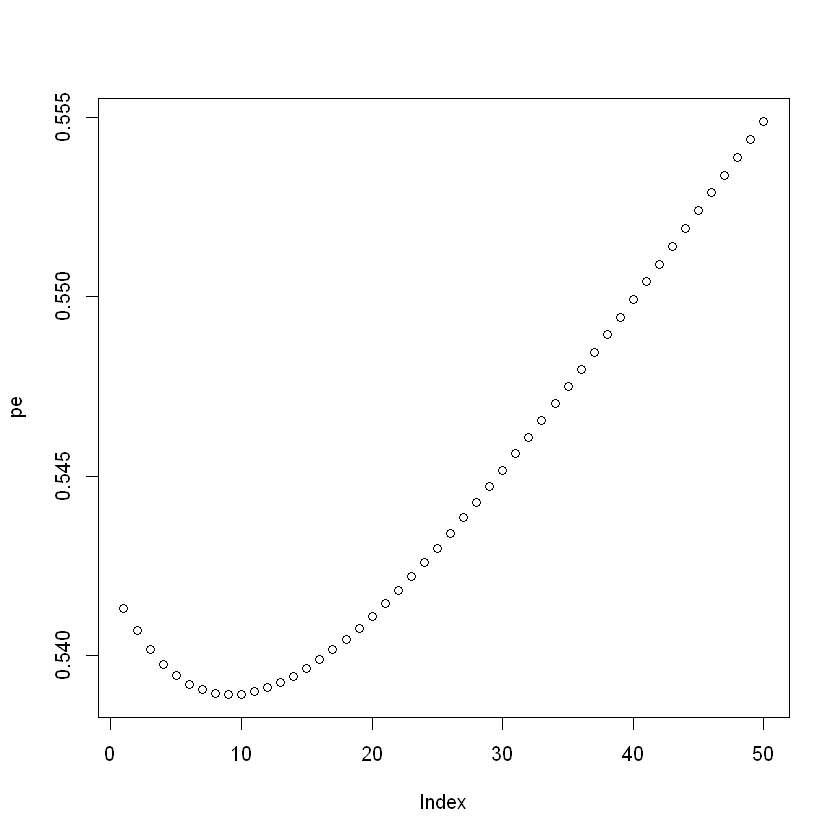

In [38]:
###pred函数的参数b为参数向量,x为自变量,返回值为因变量的预测值
#输入：回归系数b向量,数据nx
#输出：因变量y的预测值
pred <- function(b, nx)
{
  #nx=prostate[1:2,1:8]
  b <- as.vector(b)
  p <- length(b) - 1
  
  #将数据矩阵nx重新排列，每一行为一个样品，重排矩阵的原因是下面例子中调用的数据原结构为dataframe
  nx <- as.matrix(nx, ncol <- p)
  n <- dim(nx)[1]
  
  #计算预测值
  apply(t(nx)*b[2:(p+1)], 2, sum) + b[1]  
}

###mridge函数用于实现删去一个样品的岭回归
mridge=function(i,lambda,x,y) 
{
    ridgereg(lambda,x[-i,],y[-i])
}

###cvridgeregerr函数用交叉验证实现岭回归，参数依次为超参数lambda,自变量x(数据矩阵),因变量y,返回值为测试均方误差
#交叉验证详见：https://en.wikipedia.org/wiki/Cross-validation_(statistics)    
#输入：超参数lambda,自变量x(数据矩阵),因变量y
#输出：交叉验证岭回归测试均方误差
cvridgeregerr<-function(lambda,x,y){  
    
    np<-dim(x)
    n<-np[1]
    p<-np[2]
    
      
    x <- cbind(1,x)
    xy <- cbind(x,y)
    
    #生成总的自变量和因变量矩阵
    xtx=t(x)%*%x + diag(c(0, rep(lambda, p)))
    xty=t(x)%*%y
    
    #mrige函数每次删掉一组样本进行回归,最后得到n个模型的参数
    mridge <- function(ixy, lambda, xtx, xty){
        #生成删掉一组样本后所对应的自变量及因变量
        mp=length(ixy)
        ix <- ixy[-mp] 
        iy <- ixy[mp]
        
        #若利用删除样本的矩阵进行n次计算，计算量过于庞大，因此运用总矩阵先相乘再减去相对应部分，只进行一次矩阵相乘运算以减小运算量
        ixtx <- xtx - outer(ix,ix)
        ixty <- xty - iy*ix
        R <- mchol(ixtx)
        M <- mforwardsolve(R, ixty)
        mbacksolve(t(R), M)
    }
    
    #矩阵中的元素作为第一个参数输入mridge，表示去掉的数据编号，结果第i行为删去第i个样本的岭回归系数估计值
    coe<-t(apply(as.matrix(1:n,ncol=1),1,mridge,lambda,x,y))
    #coe第i行和数据矩阵第i个样本做点对点相乘，对行求和，计算测试均方误差
    mean((apply(coe*cbind(1,x),1,sum)-y)^2)
}


     
    np <- dim(x)
    n <- np[1]
    p <- np[2]
  

    #n为自变量矩阵行数,即n个样本,p为自变量矩阵列数,即p个参数
    
    #依次删掉第1至n行样本,利用ridgereg函数得到n个模型的回归参数
    coe <- t(apply(xy, 1, mridge, lambda, xtx, xty))
    
    #计算n个模型的预测值与真实值的距离,再计算这n个距离的平均值(我觉得这里应该是cbind(1, x)*coe) 
    mean((apply(coe*x, 1, sum) - y)^2)
}



###ridgeregerr函数用于计算训练均方误差  
#输入：岭回归超参数lambda，数据矩阵x，因变量y
#输出：训练均方误差
ridgeregerr=function(lambda,x,y)
{
    mean((pred(ridgereg(lambda,x,y),x)-y)^2)
}   
    
# cvridgeregerr <- function(lambda, x, y){ 
#     #mrige函数每次删掉一个样品进行回归,最后得到n个模型的参数 
#     np <- dim(x)
#     n <- np[1]
#     p <- np[2]
    
#     x <- cbind(1,x)
#     xy <- cbind(x,y)
    
#     xtx=t(x)%*%x + diag(c(0, rep(lambda, p)))
#     xty=t(x)%*%y
        

#     }

#     #n为自变量矩阵行数,即n个样本,p为自变量矩阵列数,即p个参数
    
#     #依次删掉第1至n行样本,利用ridgereg函数得到n个模型的回归参数
#     coe <- t(apply(xy, 1, mridge, lambda, xtx, xty))
    
#     #计算n个模型的预测值与真实值的距离,再计算这n个距离的平均值(我觉得这里应该是cbind(1, x)*coe) 我觉得是一样的，不是点点相乘吗-----某楸乱入
#     mean((apply(coe*x, 1, sum) - y)^2)
# }



# ###ridgeregerr的参数依次为参数调整比例,自变量,因变量,返回值为bias(只计算一个模型) 我觉得不是bais哦，是整个训练均方误差-----某楸
# ridgeregerr <- function(lambda, x, y)
# {
#   #先利用ridgereg函数回归参数,再输入pred函数求取预测值,最后计算n组样本预测值与真实值距离的平均值
#   mean((pred(ridgereg(lambda, x, y), x) - y)^2)
# }




###############################
###在不同的lambda下,比较训练均方误差和测试均方误差，以选取合适的超参数lambda
library(ElemStatLearn)
x <- as.matrix(prostate[ ,1:8])
y <- as.vector(prostate[ ,9])
LAM <- seq(0.001, 10, len=50)
#计算岭回归50个模型的训练均方误差，将结果从list展开成向量
err <- unlist(lapply(LAM, ridgeregerr, x, y))
#计算岭回归50个模型的测试均方误差，将结果从list展开成向量
pe <- unlist(lapply(LAM, cvridgeregerr, x, y))
x <- rep(1:50, 2)
plot(pe)
#取交叉验证中使测试均方误差最小的lambda
lam=LAM[which.min(pe)]


###############################################
###比较两个回归模型,另一个应该是岭回归
library(ElemStatLearn)
x <- prostate[ ,1:8]
y <- prostate[ ,9]
#用本文写的岭回归函数实现岭回归，返回beta估计值
ridgereg(lam, x, y)
library(mda)
#用mda内置函数实现岭回归(输出结果中缺少截距项)
ridge1 <- gen.ridge(prostate[ ,1:8], prostate[ ,9, drop <- FALSE], lambda =lam)  
ridge1$coe